## 1．netkeiba.comからのスクレイピング

In [1]:
import re
import time
import datetime
import requests
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_curve, roc_auc_score
from imblearn.under_sampling import RandomUnderSampler
from bs4 import BeautifulSoup
import lightgbm as lgb
from urllib.request import urlopen

In [2]:
# ネット競馬からスクレイピング
def scrape_race_results(race_id_list, pre_race_results={}):
    race_results = pre_race_results.copy()
    for race_id in tqdm(race_id_list):
        if race_id in race_results.keys():
            continue
        try:
            time.sleep(1)
            url = f'https://db.netkeiba.com/race/{race_id}'
            race_results[race_id] = pd.read_html(url)[0]
        # 存在しないrace_idを飛ばす
        except IndexError:
            continue
        # 接続が切れた時などでも途中までのデータを返せるようにする
        except Exception as e:
            print(e)
            break
        # Jupyterで停止ボタンを押した時の対処
        except:
            break
    return race_results

In [3]:
# レースIDのリストを作る
race_id_list = []
for place in range(1, 11, 1):
    for kai in range(1, 6, 1):
        for day in range(1, 13, 1):
            for r in range(1, 13, 1):
                race_id = f'2019{str(place).zfill(2)}{str(kai).zfill(2)}{str(day).zfill(2)}{str(r).zfill(2)}'
                race_id_list.append(race_id)

In [4]:
# スクレイピングしてデータを保存(再実行すると時間かかるのでコメント)
# data = scrape_race_results(race_id_list)

# indexをrace_idにする
# for key in data:
#     data[key].index = [key] * len(data[key])

# DataFrame型にして一つのデータにまとめる
# results = pd.concat([data[key] for key in data], sort=False)

# pickleファイルに保存
# results.to_pickle('results.pickle')

## 2．ロジスティック回帰で競馬予測

In [5]:
def preprocessing(results):
    df = results.copy()
    
    # 着順に数字以外の文字列が含まれているものを取り除く
    df = df[~(df['着順'].astype(str).str.contains('\D'))]
    df['着順'] = df['着順'].astype(int)
    
    # 性齢を性と年齢に分ける
    df['性'] = df['性齢'].map(lambda x: str(x)[0])
    df['年齢'] = df['性齢'].map(lambda x: str(x)[1:]).astype(int)
    
    # 馬体重を体重と体重変化に分ける
    df['体重'] = df['馬体重'].str.split('(', expand=True)[0].astype(int)
    df['体重変化'] = df['馬体重'].str.split('(', expand=True)[1].str[:-1].astype(int)
    
    # 単勝をfloatに変換
    df['単勝'] = df['単勝'].astype(float)
    
    # 不要な列を削除
    df.drop(['タイム', '着差', '調教師', '性齢', '馬体重', '馬名'], axis=1, inplace=True)
    
    return df

In [6]:
# 保存したpickleファイルからデータ取得
results = pd.read_pickle('results.pickle')

In [7]:
# 前処理
df = preprocessing(results)

In [8]:
# 4着以下をすべて4にする
clip_rank = lambda x: x if x < 4 else 4
df['rank'] = df['着順'].map(clip_rank)

# 不要な列を削除
df.drop(['着順'], axis=1, inplace=True)

# カテゴリ変数をダミー変数化
df_d = pd.get_dummies(df)

In [9]:
# 訓練データとテストデータに分ける
X = df_d.drop(['rank'], axis=1)
y = df_d['rank']
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.3, random_state=0)

In [10]:
# アンダーサンプリング
rank_1 = y_train.value_counts()[1]
rank_2 = y_train.value_counts()[2]
rank_3 = y_train.value_counts()[3]

rus = RandomUnderSampler(sampling_strategy={1: rank_1, 2: rank_2, 3: rank_3, 4: rank_1}, random_state=71)
X_train_rus, y_train_rus = rus.fit_resample(X_train, y_train)

In [11]:
# 訓練
model = LogisticRegression()
model.fit(X_train_rus, y_train_rus)

C:\Users\y_ono\Anaconda\lib\site-packages\sklearn\linear_model\_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


LogisticRegression()

In [12]:
# スコアを表示
print(model.score(X_train, y_train), model.score(X_test, y_test))

0.564004608574374 0.5614742501414828


In [13]:
# 予測結果を確認
y_pred = model.predict(X_test)
pred_df = pd.DataFrame({'pred': y_pred, 'actual': y_test})
pred_df[pred_df['pred'] == 1]['actual'].value_counts()

4    1754
1     684
2     612
3     474
Name: actual, dtype: int64

In [14]:
# 回帰係数の確認
coefs = pd.Series(model.coef_[0], index=X.columns).sort_values()
coefs[['枠番', '馬番', '斤量', '単勝', '人気', '年齢', '体重', '体重変化']]

枠番     -0.003471
馬番      0.002468
斤量      0.004374
単勝     -0.008760
人気     -0.104455
年齢     -0.021528
体重      0.001070
体重変化   -0.000820
dtype: float64

## 3．ランダムフォレストで競馬予測

In [15]:
def scrape_race_info(race_id_list):
    race_infos = {}
    for race_id in tqdm(race_id_list):
        try:
            url = f'https://db.netkeiba.com/race/{race_id}'
            html = requests.get(url)
            html.encoding = 'EUC-JP'
            soup = BeautifulSoup(html.text, 'html.parser')

            texts = soup.find('div', attrs={'class': 'data_intro'}).find_all('p')[0].text + soup.find('div', attrs={'class': 'data_intro'}).find_all('p')[1].text
            info = re.findall(r'\w+', texts)
            info_dict = {}
            for text in info:
                if text in ['芝', 'ダート']:
                    info_dict['race_type'] = text
                if '障' in text:
                    info_dict['race_type'] = '障害'
                if 'm' in text:
                    info_dict['course_len'] = int(re.findall(r'\d+', text)[0])
                if text in ['良', '稍重', '重', '不良']:
                    info_dict['ground_state'] = text
                if text in ['曇', '晴', '雨', '小雨', '小雪', '雪']:
                    info_dict['weather'] = text
                if '年' in text:
                    info_dict['date'] = text
            race_infos[race_id] = info_dict
            time.sleep(1)
        except IndexError:
            continue
        except Exception as e:
            print(e)
            break
        except:
            break
    return race_infos

In [16]:
#レースID一覧を取得してスクレイピング(再実行すると時間かかるのでコメント)
# race_id_list = results.index.unique()
# race_infos = scrape_race_info(race_id_list)

#DataFrame型にする
# race_infos = pd.DataFrame(race_infos).T

# resultsに結合
# results_addinfo = results.merge(race_infos, left_index=True, right_index=True, how='inner')

# pickleファイルに保存
# results_addinfo.to_pickle('results2.pickle')
# race_infos.to_pickle('race_infos.pickle')

In [17]:
# 保存したpickleファイルからデータ取得
results = pd.read_pickle('results2.pickle')
race_infos = pd.read_pickle('race_infos.pickle')

In [18]:
#date列の処理を追加
def preprocessing(results):
    df = results.copy()

    # 着順に数字以外の文字列が含まれているものを取り除く
    df = df[~(df['着順'].astype(str).str.contains('\D'))]
    df['着順'] = df['着順'].astype(int)

    # 性齢を性と年齢に分ける
    df['性'] = df['性齢'].map(lambda x: str(x)[0])
    df['年齢'] = df['性齢'].map(lambda x: str(x)[1:]).astype(int)

    # 馬体重を体重と体重変化に分ける
    df['体重'] = df['馬体重'].str.split('(', expand=True)[0].astype(int)
    df['体重変化'] = df['馬体重'].str.split('(', expand=True)[1].str[:-1].astype(int)

    # データをint, floatに変換
    df['単勝'] = df['単勝'].astype(float)
    df['course_len'] = df['course_len'].astype(int)
    
    # 不要な列を削除
    df.drop(['タイム', '着差', '調教師', '性齢', '馬体重', '馬名', '騎手'], axis=1, inplace=True)
    
    df['date'] = pd.to_datetime(df['date'], format='%Y年%m月%d日')

    return df

In [19]:
# 前処理
results_p = preprocessing(results)

In [20]:
# 時系列に沿ってデータを分割
def split_data(df, test_size=0.3):
    sorted_id_list = df.sort_values('date').index.unique()   
    train_id_list = sorted_id_list[:round(len(sorted_id_list) * (1 - test_size))]
    test_id_list = sorted_id_list[round(len(sorted_id_list) * (1 - test_size)):]
    train = df.loc[train_id_list]
    test = df.loc[test_id_list]
    return train, test

In [21]:
# カテゴリ変数をダミー変数化
results_d = pd.get_dummies(results_p)

# 4着以下をすべて4にする
results_d['rank'] = results_d['着順'].map(lambda x: x if x < 4 else 4)

In [22]:
# 訓練データとテストデータに分ける
train, test = split_data(results_d, test_size=0.3)
X_train = train.drop(['着順', 'date', 'rank'], axis=1)
y_train = train['rank']
X_test = test.drop(['着順', 'date', 'rank'], axis=1)
y_test = test['rank']

In [23]:
# アンダーサンプリング
rank_1 = train['rank'].value_counts()[1]
rank_2 = train['rank'].value_counts()[2]
rank_3 = train['rank'].value_counts()[3]

rus = RandomUnderSampler(sampling_strategy={1: rank_1, 2: rank_2, 3: rank_3, 4: rank_1}, random_state=71)
X_train_rus, y_train_rus = rus.fit_resample(X_train, y_train)

In [24]:
# ランダムフォレストによる予測
clf = RandomForestClassifier(random_state=0)
clf.fit(X_train_rus, y_train_rus)
print(clf.score(X_train, y_train), clf.score(X_test, y_test))

0.7186886829474447 0.5379887070259453


## 4．モデル作成

In [25]:
# 前処理
results_p = preprocessing(results)

In [26]:
# 着順を0or1にする
results_p['rank'] = results_p['着順'].map(lambda x: 1 if x < 4 else 0)

# 不要な列を削除
results_p.drop(['着順'], axis=1, inplace=True)

# カテゴリ変数をダミー変数化
results_d = pd.get_dummies(results_p)

In [27]:
# 訓練データとテストデータに分ける
train, test = split_data(results_d)
X_train = train.drop(['rank', 'date'], axis=1)
y_train = train['rank']
X_test = test.drop(['rank', 'date'], axis=1)
y_test = test['rank']

### 4.1　ランダムフォレスト

In [28]:
# ランダムフォレストによる予測モデル作成
rf = RandomForestClassifier(random_state=100)
rf.fit(X_train, y_train)

RandomForestClassifier(random_state=100)

In [29]:
y_pred = rf.predict_proba(X_test)[:, 1]

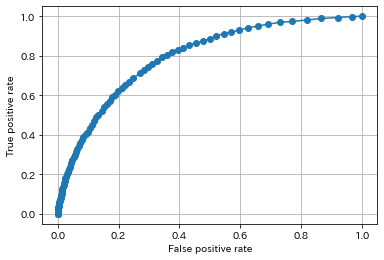

In [30]:
#ROC曲線の表示
fpr, tpr, thresholds = roc_curve(y_test, y_pred)
plt.plot(fpr, tpr, marker='o')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.grid()
plt.show()

In [31]:
#AUCスコアの表示
roc_auc_score(y_test, y_pred)

0.7947945783543751

In [32]:
# パラメータの調整
params = {
    'min_samples_split': 500,
    'max_depth': None,
    'n_estimators': 60,
    'criterion': 'entropy',
    'class_weight': 'balanced',
    'random_state': 100,
}

rf = RandomForestClassifier(**params)
rf.fit(X_train, y_train)
y_pred_train = rf.predict_proba(X_train)[:, 1]
y_pred = rf.predict_proba(X_test)[:, 1]
print(roc_auc_score(y_train, y_pred_train))
print(roc_auc_score(y_test, y_pred))

0.8274175796356155
0.8089095833883719


In [33]:
# 変数の重要度の表示
importances = pd.DataFrame({'features': X_train.columns, 'importance': rf.feature_importances_})
importances.sort_values('importance', ascending=False)[:20]

,features,importance
3,単勝,0.514805
4,人気,0.392319
7,体重,0.019810
6,年齢,0.012486
8,体重変化,0.011362
1,馬番,0.009189
5,course_len,0.009165
2,斤量,0.009003
0,枠番,0.004912
24,性_牡,0.002467


### 4.2　勾配ブースティング木

In [34]:
# LightGBMによる予測モデル作成

# パラメータの調整
params = {
    'num_leaves': 4,
    'n_estimators': 55,
    'class_weight': 'balanced',
    'random_state': 100
}

lgb_clf = lgb.LGBMClassifier(**params)
lgb_clf.fit(X_train.values, y_train.values)
y_pred_train = lgb_clf.predict_proba(X_train)[:, 1]
y_pred = lgb_clf.predict_proba(X_test)[:, 1]
print(roc_auc_score(y_train, y_pred_train))
print(roc_auc_score(y_test, y_pred))

0.8170484798993838
0.8114221196214765


In [35]:
# 変数の重要度の表示
importances = pd.DataFrame({'features': X_train.columns, 'importance': lgb_clf.feature_importances_})
importances.sort_values('importance', ascending=False)[:20]

,features,importance
3,単勝,122
4,人気,17
6,年齢,9
8,体重変化,6
2,斤量,3
1,馬番,3
7,体重,2
24,性_牡,1
5,course_len,1
21,ground_state_重,1


## 5．過去のレースデータを入れる

In [36]:
def scrape_race_results(race_id_list):
    # race_idをkeyにしてDataFrame型を格納
    race_results = {}
    for race_id in tqdm(race_id_list):
        try:
            time.sleep(1)
            url = f'https://db.netkeiba.com/race/{race_id}'
            # メインとなるテーブルデータを取得
            df = pd.read_html(url)[0]
            
            html = requests.get(url)
            html.encoding = 'EUC-JP'
            soup = BeautifulSoup(html.text, 'html.parser')
            
            # 馬idと騎手idをスクレイピング
            horse_id_list = []
            horse_a_list = soup.find('table', attrs={'summary': 'レース結果'}).find_all('a', attrs={'href': re.compile('^/horse')})
            for a in horse_a_list:
                horse_id = re.findall(r'\d+', a['href'])
                horse_id_list.append(horse_id[0])
                
            jockey_id_list = []
            jockey_a_list = soup.find('table', attrs={'summary': 'レース結果'}).find_all('a', attrs={'href': re.compile('^/jockey')})
            for a in jockey_a_list:
                jockey_id = re.findall(r'\d+', a['href'])
                jockey_id_list.append(jockey_id[0])
                
            df['horse_id'] = horse_id_list
            df['jockey_id'] = jockey_id_list
            
            race_results[race_id] = df
        # 存在しないrace_idを飛ばす
        except IndexError:
            continue
        # 接続が切れたときなどでも途中までのデータを返せるようにする
        except Exception as e:
            print(e)
            break
        # Jpyterで停止ボタンを押したときの対処
        except:
            break
    return race_results

In [37]:
# スクレイピングしてデータを保存(再実行すると時間かかるのでコメント)
# race_id_list = results.index.unique()
# race_results = scrape_race_results(race_id_list)

# indexをrace_idにする
# for key in race_results:
#     race_results[key].index = [key] * len(race_results[key])

# 一つのDataFrame型のデータにまとめる
# race_results_df = pd.concat([race_results[key] for key in race_results])

#race_infosをmerge
# results = race_results_df.merge(race_infos, left_index=True,
#     right_index=True, how='left')

# pickleファイルに保存
# results.to_pickle('results3.pickle')

In [38]:
# 保存したpickleファイルからデータ取得
results = pd.read_pickle('results3.pickle')

In [39]:
def scrape_horse_results(horse_id_list):
    # horse_idをkeyにしてDataFrame型を格納
    horse_results = {}
    for horse_id in tqdm(horse_id_list):
        try:
            time.sleep(1)
            url = f'https://db.netkeiba.com/horse/{horse_id}'
            # メインとなるテーブルデータを取得
            df = pd.read_html(url)[3]
            # 受賞歴がある馬の場合、4番目に受賞歴テーブルが来るため、5番目のデータを取得する
            if df.columns[0] == '受賞歴':
                df = pd.read_html(url)[4]
            horse_results[horse_id] = df
        # 存在しないrace_idを飛ばす
        except IndexError:
            continue
        # 接続が切れたときなどでも途中までのデータを返せるようにする
        except Exception as e:
            print(e)
            break
        # Jupyterで停止ボタンを押したときの対処
        except:
            break
    return horse_results

In [40]:
# スクレイピングしてデータを保存(再実行すると時間かかるのでコメント)
# horse_id_list = results['horse_id'].unique()
# horse_results = scrape_horse_results(horse_id_list)

# インデックスをhorse_idにする
# for key in horse_results:
#     horse_results[key].index = [key] * len(horse_results[key])
    
# 一つのDataFrame型のデータにまとめる
# horse_results = pd.concat([horse_results[key] for key in horse_results])

# pickleファイルに保存
# horse_results.to_pickle('horse_results.pickle')

In [41]:
# 保存したpickleファイルからデータ取得
horse_results = pd.read_pickle('horse_results.pickle')

### 5.1　HorseResultsクラス

In [42]:
class HorseResults:
    def __init__(self, horse_results):
        self.horse_results = horse_results[['日付', '着順', '賞金']]
        self.preprocessing()
        
    def preprocessing(self):
        df = self.horse_results.copy()
        
        # 着順に数字以外の文字列が含まれているものを取り除く
        df['着順'] = pd.to_numeric(df['着順'], errors='coerce')
        df.dropna(subset=['着順'], inplace=True)
        df['着順'] = df['着順'].astype(int)
        
        df['date'] = pd.to_datetime(df['日付'])
        df.drop(['日付'], axis=1, inplace=True)
        
        # 賞金の欠損値を0で埋める
        df['賞金'].fillna(0, inplace=True)
        
        self.horse_results = df
    
    def average(self, horse_id_list, date, n_samples='all'):
        target_df = self.horse_results.loc[horse_id_list]
        
        # 過去何走分取り出すか指定
        if n_samples == 'all':
            filtered_df = target_df[target_df['date'] < date]
        elif n_samples > 0:
            filtered_df = target_df[target_df['date'] < date].sort_values('date', ascending=False).groupby(level=0).head(n_samples)
        else:
            raise Exception('n_samples must be integer')
            
        average = filtered_df.groupby(level=0)[['着順', '賞金']].mean()
        rename_columns = average.rename(columns={'着順': f'着順_{n_samples}R', '賞金': f'賞金_{n_samples}R'})
        return rename_columns
    
    def merge(self, results, date, n_samples='all'):
        df = results[results['date'] == date]
        horse_id_list = df['horse_id']
        merged_df = df.merge(self.average(horse_id_list, date, n_samples), left_on='horse_id', right_index=True, how='left')
        return merged_df
    
    def merge_all(self, results, n_samples='all'):
        date_list = results['date'].unique()
        merged_df = pd.concat([self.merge(results, date, n_samples) for date in date_list])
        return merged_df

In [43]:
# 前処理
results_p = preprocessing(results)

In [44]:
# HorseResultsクラスを使って過去成績データを結合
hr = HorseResults(horse_results)
results_5R = hr.merge_all(results_p, n_samples=5)
results_5R['rank'] = results_5R['着順'].map(lambda x: 1 if x < 4 else 0)
# results_5R.drop(['着順', '騎手', 'horse_id', '馬名'], axis=1, inplace=True)
results_5R.drop(['着順', 'horse_id'], axis=1, inplace=True)
results_d = pd.get_dummies(results_5R)

In [45]:
# 時系列に沿ってデータを分割
def split_data(df, test_size=0.3):
    sorted_id_list = df.sort_values('date').index.unique()   
    train_id_list = sorted_id_list[:round(len(sorted_id_list) * (1 - test_size))]
    test_id_list = sorted_id_list[round(len(sorted_id_list) * (1 - test_size)):]
    train = df.loc[train_id_list].drop(['date'], axis=1)
    test = df.loc[test_id_list].drop(['date'], axis=1)
    return train, test

In [46]:
# 訓練データとテストデータに分ける
train, test = split_data(results_d)
X_train = train.drop(['rank'], axis=1)
y_train = train['rank']
X_test = test.drop(['rank'], axis=1)
y_test = test['rank']

In [47]:
# LightGBMで学習

# パラメータの調整
params = {
    'num_leaves': 4,
    'n_estimators': 70,
    'class_weight': 'balanced',
    'random_state': 100
}

lgb_clf = lgb.LGBMClassifier(**params)
lgb_clf.fit(X_train.values, y_train.values)
y_pred_train = lgb_clf.predict_proba(X_train)[:, 1]
y_pred = lgb_clf.predict_proba(X_test)[:, 1]
print(roc_auc_score(y_train, y_pred_train))
print(roc_auc_score(y_test, y_pred))

0.8184300744401398
0.8121180102999034


In [48]:
# 変数の重要度を出力
importances = pd.DataFrame(
    {"features": X_train.columns, "importance": lgb_clf.feature_importances_}
)
importances.sort_values('importance', ascending=False)[:20]

,features,importance
3,単勝,117
9,着順_5R,20
4,人気,17
6,年齢,8
10,賞金_5R,8
131,jockey_id_01164,7
8,体重変化,4
2,斤量,4
1,馬番,3
70,jockey_id_01087,3


## 6．払い戻しデータのスクレイピング

In [49]:
def scrape_return_tables(race_id_list, pre_return_tables={}):
    return_tables = pre_return_tables
    for race_id in tqdm(race_id_list):
        if race_id in return_tables.keys():
            continue
        try:
            time.sleep(1)
            url = f'https://db.netkeiba.com/race/{race_id}'
            
            # 複勝やワイドなどが区切られてしまうため、改行コードを文字列に変換して後でsplitする
            f = urlopen(url)
            html = f.read()
            html = html.replace(b'<br />', b'br')            
            dfs = pd.read_html(html)
            
            # dfsの2番目に単勝～馬連、3番目にワイド～3連単がある
            return_tables[race_id] = pd.concat([dfs[1], dfs[2]])
            
        # 存在しないrace_idを飛ばす
        except IndexError:
            continue
        # 接続が切れた時などでも途中までのデータを返せるようにする
        except Exception as e:
            print(e)
            break
        # Jupyterで停止ボタンを押した時の対処
        except:
            break
    return return_tables

In [50]:
train, test = split_data(results_p)

In [51]:
# スクレイピングしてデータを保存(再実行すると時間かかるのでコメント)
# race_id_list = test.index.unique()
# return_tables = scrape_return_tables(race_id_list)

# インデックスをrace_idにする
# for key in return_tables.keys():
#     return_tables[key].index = [key]*len(return_tables[key])

# 一つのDataFrame型のデータにまとめる
# return_tables = pd.concat([return_tables[key] for key in return_tables.keys()])

# pickleファイルに保存
# return_tables.to_pickle('return_tables.pickle')

In [52]:
# 保存したpickleファイルからデータ取得
return_tables = pd.read_pickle('return_tables.pickle')

### 6.1　Returnクラス

In [53]:
class Return:
    def __init__(self, return_tables):
        self.return_tables = return_tables
    
    @property
    def fukusho(self):
        # 複勝の勝ち馬と払い戻しのデータを取り出す
        fukusho = self.return_tables[self.return_tables[0] == '複勝'][[1, 2]]
        
        # 勝ち馬
        wins = fukusho[1].str.split('br', expand=True)[[0, 1, 2]]
        wins.columns = ['win_0', 'win_1', 'win_2']
        
        # 払い戻し
        returns = fukusho[2].str.split('br', expand=True)[[0, 1, 2]]
        returns.columns = ['return_0', 'return_1', 'return_2']
        
        df = pd.concat([wins, returns], axis=1)
        
        # int型に変換できないデータがあるので処理
        for column in df.columns:
            df[column] = df[column].str.replace(',', '')
            
        df = df.fillna(0).astype(int)
        
        return df

In [54]:
rt = Return(return_tables)

In [55]:
rt.fukusho

,win_0,win_1,win_2,return_0,return_1,return_2
201906040103,6,7,3,150,110,120
201906040102,5,3,1,250,110,1040
201906040104,1,7,6,110,210,430
201906040106,8,5,4,150,110,250
201906040105,4,3,1,110,120,310
...,...,...,...,...,...,...
201906050904,16,15,6,210,460,390
201906050909,2,14,3,440,160,180
201906050908,1,14,13,240,260,110
201906050910,14,12,1,540,380,290


### 6.2　ModelEvaluatorクラス

In [56]:
class ModelEvaluator:
    def __init__(self, model, return_tables):
        self.model = model
        self.fukusho = Return(return_tables).fukusho
        
    def predict_proba(self, x):
        # 1（3着以内）になる確率を予測
        return self.model.predict_proba(x)[:, 1]
    
    def predict(self, x, threshold=0.5):
        # thresholdの値によってpredict_probaで出した値を0か1に決定する
        y_pred = self.predict_proba(x)
        return [0 if p < threshold else 1 for p in y_pred]
    
    def score(self, y_true, x):
        # スコアを表示
        return roc_auc_score(y_true, self.predict_proba(x))
    
    def feature_importance(self, x, n_display=20):
        # 変数の重要度を出力
        importances = pd.DataFrame(
            {"features": x.columns, "importance": self.model.feature_importances_}
        )
        return importances.sort_values('importance', ascending=False)[:n_display]
    
    def pred_table(self, x, threshold=0.5, bet_only=True):
        # 予測したレースIDと馬番を出力する
        pred_table = x.copy()[['馬番']]
        pred_table['pred'] = self.predict(x, threshold)
        
        if bet_only:
            return pred_table[pred_table['pred'] == 1]['馬番']
        
        return pred_table
    
    def calculate_return(self, x, threshold=0.5):
        # 回収率を計算
        pred_table = self.pred_table(x, threshold)
        money = -100 * len(pred_table)
        df = self.fukusho.copy()
        df = df.merge(pred_table, left_index=True, right_index=True, how='right')
        for i in range(3):
            money += df[df[f'win_{i}'] == df['馬番']][f'return_{i}'].sum()
        
        return int(money)

In [57]:
me = ModelEvaluator(lgb_clf, return_tables)
me.calculate_return(X_test)

-117130

In [58]:
# シミュレーション実行
gain = {}
n_samples = 100
for i in tqdm(range(n_samples)):
    threshold = i / n_samples
    gain[threshold] = me.calculate_return(X_test, threshold)

100%|██████████| 100/100 [00:13<00:00,  7.29it/s]


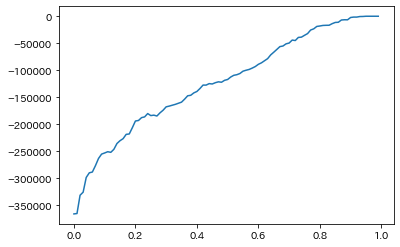

In [59]:
pd.Series(gain).plot()